In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/My\ paper

/content/drive/Shareddrives/My paper


In [ ]:
import math
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Import the Keras libraries and packages
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LSTM, Dropout, TimeDistributed, Embedding, Input
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from keras import backend as K

In [ ]:
from imblearn.under_sampling import NearMiss

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn import tree
from scipy.stats import spearmanr
from collections import Counter

## 處理 y

In [ ]:
data = pd.read_csv('./Customer Value Prediction/TABLES/Event Sequence.csv')

In [ ]:
data.columns

Index(['MemberID', 'TotalSalesAmount', 'Active', 'VIP', 'bh', 'TimeDiff'], dtype='object')

In [ ]:
len(data)

3449784

In [ ]:
data.describe()

,TotalSalesAmount,Active,VIP,TimeDiff
count,3.449784e+06,3.449784e+06,3.449784e+06,3.449784e+06
mean,1.405740e+03,3.001405e-01,1.655625e-01,7.072227e+03
std,4.251320e+03,4.583189e-01,3.716875e-01,4.046252e+04
min,-1.680000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.406000e+03,1.000000e+00,0.000000e+00,1.000000e+00
max,1.814280e+05,1.000000e+00,1.000000e+00,5.270230e+05


## 處理 Event Sequence -> 每個會員的資料合成一個 row

In [ ]:
data['bh_codes'] = pd.Categorical(data.bh).codes
data['bh_codes'] = data['bh_codes'] + 1 # 因為之後會補 0 

In [ ]:
bhs = pd.DataFrame(data.groupby('MemberID')['bh'].apply(list))
bh_codes= pd.DataFrame(data.groupby('MemberID')['bh_codes'].apply(list))
TimeDiffs = pd.DataFrame(data.groupby('MemberID')['TimeDiff'].apply(list))

In [ ]:
data_unified = pd.merge(bhs, bh_codes, on='MemberID')
data_unified = pd.merge(data_unified, TimeDiffs, on='MemberID')

In [ ]:
# get label
label_data = data.drop_duplicates(subset=['MemberID'],keep='last')[['MemberID', 'TotalSalesAmount', 'Active', 'VIP']]

In [ ]:
# merge X data and y data
data_unified = pd.merge(data_unified, label_data, on='MemberID')

In [ ]:
len(data_unified)

83931

In [ ]:
Counter(data_unified['VIP'])

Counter({0.0: 72733, 1.0: 11198})

## 準備 undersampling

In [ ]:
all_event = np.array(data_unified['bh_codes'])

In [ ]:
event_cols = []
PADDING_LENGTH = 60

for i in range(1, PADDING_LENGTH+1):
  event_cols.append('e_'+ str(i))

In [ ]:
X = pd.DataFrame(pad_sequences(all_event, maxlen=PADDING_LENGTH), columns=event_cols)
y = data_unified['VIP']

In [ ]:
X.head()

,e_1,e_2,e_3,e_4,e_5,e_6,e_7,e_8,e_9,e_10,...,e_51,e_52,e_53,e_54,e_55,e_56,e_57,e_58,e_59,e_60
0,6,6,6,6,6,6,6,6,6,10,...,9,9,8,9,9,8,9,9,8,9
1,6,6,10,6,6,6,6,8,6,6,...,9,10,1,8,9,9,10,10,10,9
2,9,9,8,10,8,10,8,10,8,10,...,8,9,9,9,9,9,10,10,10,10
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,8,10,8
4,8,8,9,9,9,9,8,8,9,9,...,10,8,10,8,10,8,10,8,8,9


In [ ]:
counter = Counter(y)
print(counter)

Counter({0.0: 72733, 1.0: 11198})


## 做 undersampling

In [ ]:
class DataUds():
  def __init__(self, minor_weight, X, y):
    self.minor_weight = minor_weight
    self.X = X
    self.y = y

    self.reset()

  def reset(self):
    self.X_res = []
    self.y_res = []

  def get_major_num(self):
    counter = Counter(self.y)
    print('Orginal num:', counter)
    major_num = int(counter[1] * ((1-self.minor_weight)/self.minor_weight))
    return major_num

  def undersample(self, major_num):
    nm = NearMiss(sampling_strategy={0: major_num}, version=1)
    self.X_res, self.y_res = nm.fit_resample(X, y) 
    print('Undersmapling num:', Counter(self.y_res))

  def run(self):
    major_num = self.get_major_num()
    self.undersample(major_num)

In [ ]:
uds_1 = DataUds(0.5, X, y)
uds_1.run()

Orginal num: Counter({0.0: 72733, 1.0: 11198})


In [ ]:
X_res = uds_1.X_res
y_res = uds_1.y_res

In [ ]:
X_uds = np.array(X_res[event_cols]).reshape(len(X_res), PADDING_LENGTH, 1)
y_uds = y_res

In [ ]:
data_uds = pd.concat([X_res, y_res], axis=1)

In [ ]:
# data_uds.to_csv('Event Sequence Undersampled Data.csv', index=False)

## 切割訓練測試集

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_uds, y_uds, test_size=0.2, random_state=123)

In [ ]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

17916 17916 4480 4480


In [ ]:
X_train.shape

(17916, 60, 1)

In [ ]:
y_train.shape

(17916,)

In [ ]:
Counter(y_train)

Counter({0.0: 9004, 1.0: 8912})

In [ ]:
Counter(y_test)

Counter({0.0: 2194, 1.0: 2286})

In [ ]:
data_uds['Train/Test'] = ['Test'] * len(data_uds)
data_uds.loc[y_train.index, 'Train/Test'] = 'Train'

In [ ]:
data_uds.to_csv('Train Test Data.csv', index=False)

## LSTM

## model 試驗

In [ ]:
model = Sequential()
  
model.add(Embedding(input_dim=11, output_dim=8))
model.add(LSTM(64, input_shape=(PADDING_LENGTH, 2), return_sequences=True))        
model.add(Dense(1, activation='sigmoid'))

opt = Adam(lr=0.01)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 8)           88        
                                                                 
 lstm_3 (LSTM)               (None, None, 64)          18688     
                                                                 
 dense_3 (Dense)             (None, None, 1)           65        
                                                                 
Total params: 18,841
Trainable params: 18,841
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)
EPOCHS = 20
BATCH_SIZE = 512
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=[callback], verbose=1)

Epoch 1/20
28/28 [==============================] - 10s 277ms/step - loss: 0.4021 - accuracy: 0.8490 - val_loss: 0.3250 - val_accuracy: 0.8920
Epoch 2/20
28/28 [==============================] - 7s 255ms/step - loss: 0.3139 - accuracy: 0.8972 - val_loss: 0.3127 - val_accuracy: 0.8954
Epoch 3/20
28/28 [==============================] - 7s 252ms/step - loss: 0.2965 - accuracy: 0.8980 - val_loss: 0.2804 - val_accuracy: 0.8942
Epoch 4/20
28/28 [==============================] - 7s 254ms/step - loss: 0.2770 - accuracy: 0.8955 - val_loss: 0.2732 - val_accuracy: 0.8924
Epoch 5/20
28/28 [==============================] - 7s 255ms/step - loss: 0.2663 - accuracy: 0.9004 - val_loss: 0.2723 - val_accuracy: 0.8954
Epoch 6/20
28/28 [==============================] - 7s 257ms/step - loss: 0.2618 - accuracy: 0.9028 - val_loss: 0.2615 - val_accuracy: 0.9007
Epoch 7/20
28/28 [==============================] - 7s 259ms/step - loss: 0.2574 - accuracy: 0.9060 - val_loss: 0.2581 - val_accuracy: 0.9036
Epoch

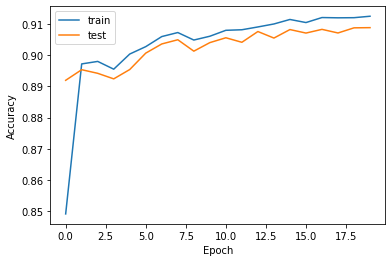

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
prediction = model.predict(X_test)

In [ ]:
y_pred = (prediction[:, PADDING_LENGTH-1] > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1 score: ', f1_score(y_pred, y_test))
print('AUC score: ', roc_auc_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.9381696428571429
F1 score:  0.9387574618615963
AUC score:  0.9381841804164589
Confusion matrix:


array([[2080,  114],
       [ 163, 2123]])

In [ ]:
labels = ['NotVIP', 'VIP']

In [ ]:
Counter(y_test)

Counter({0.0: 2194, 1.0: 2286})

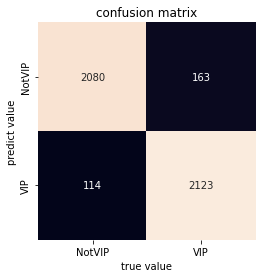

In [ ]:
matric = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(4,4))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",classification_report(y_pred, y_test,labels=[0, 1],target_names=labels))

report:
               precision    recall  f1-score   support

      NotVIP       0.95      0.93      0.94      2243
         VIP       0.93      0.95      0.94      2237

    accuracy                           0.94      4480
   macro avg       0.94      0.94      0.94      4480
weighted avg       0.94      0.94      0.94      4480



In [ ]:
X_all = np.rot90(np.array(X).reshape(len(X), 1, PADDING_LENGTH), 3, (1, 2))
prediction_all = model.predict(X_all)

In [ ]:
y_pred_all = (prediction_all[:, -1] > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred_all, y))
print('F1 score: ', f1_score(y_pred_all, y))
print('AUC score: ', roc_auc_score(y_pred_all, y))
print('Confusion matrix:')
confusion_matrix(y_pred_all, y)

Accuracy of the model :  0.2689947695130524
F1 score:  0.25450789793438644
AUC score:  0.5453914230306358
Confusion matrix:


array([[12104,   725],
       [60629, 10473]])

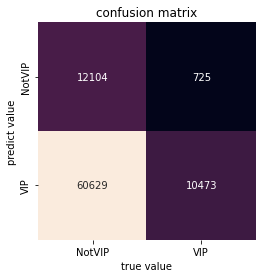

In [ ]:
matric = confusion_matrix(y_pred_all, y)
plt.figure(figsize=(4,4))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",classification_report(y_pred_all, y,labels=[0, 1],target_names=labels))

report:
               precision    recall  f1-score   support

      NotVIP       0.17      0.94      0.28     12829
         VIP       0.94      0.15      0.25     71102

    accuracy                           0.27     83931
   macro avg       0.55      0.55      0.27     83931
weighted avg       0.82      0.27      0.26     83931



## 取得每次 output

In [ ]:
model.layers[0].get_weights()[0].shape

(11, 8)

In [ ]:
def get_layer_output(X, idx):
  get_output = K.function([model.layers[0].input], [model.layers[idx].output])
  return get_output([X])

In [ ]:
layer_output_1 = get_layer_output(X_test, 0)
layer_output_2 = get_layer_output(X_test, 2)

In [ ]:
ot = pd.DataFrame(layer_output_2[0][:, PADDING_LENGTH-1], columns=['P'])
ot[ot['P']>0.5]

,P
0,0.990734
3,0.989843
4,0.990498
5,0.990704
6,0.989714
...,...
4471,0.989869
4472,0.990693
4475,0.990679
4476,0.990549


## 結果解釋

In [ ]:
bh_dict = ['None', 'add', 'checkout', 'purchase', 'register', 'search', 'traffic', 'viewactivity', 'viewcategory', 'viewmainpage', 'viewproduct']

In [ ]:
def get_output_df(idx):
  bh_eg = list(X_test[idx].reshape(1,PADDING_LENGTH)[0])
  bh_eg = [i for i in bh_eg if i != 0] # 把 padding 的 event 拿掉
  output_eg = list(layer_output_2[0][idx].reshape(1,PADDING_LENGTH)[0])[-len(bh_eg):]
  bh_name_eg = [bh_dict[x] for x in bh_eg]

  df_eg = pd.DataFrame([idx] * len(bh_eg), columns=['Member'])
  df_eg['bh'] = bh_name_eg
  df_eg['Output'] = output_eg

  return df_eg

In [ ]:
def output_ex(idx):
  eg_1 = list(X_test[idx].reshape(1,PADDING_LENGTH)[0])
  eg_1 = [i for i in eg_1 if i != 0] # 把 padding 的 event 拿掉
  output_1 = list(layer_output_2[0][idx].reshape(1,PADDING_LENGTH)[0])[-len(eg_1):]

  # 開始繪圖
  x_axis = range(len(eg_1))
  base = [0.5] * len(x_axis)
  eg_1_bh = [bh_dict[x] for x in eg_1]

  plt.figure(figsize=(12,6))
  plt.plot(x_axis, output_1, color="red", marker='o', markerfacecolor='black', markersize=4)
  plt.plot(x_axis, base, color="blue", linestyle='dashed')
  plt.xticks(x_axis,eg_1_bh,rotation=90)
  plt.xlabel('Behavior Events')
  plt.ylabel('P(VIP)')
  plt.show()

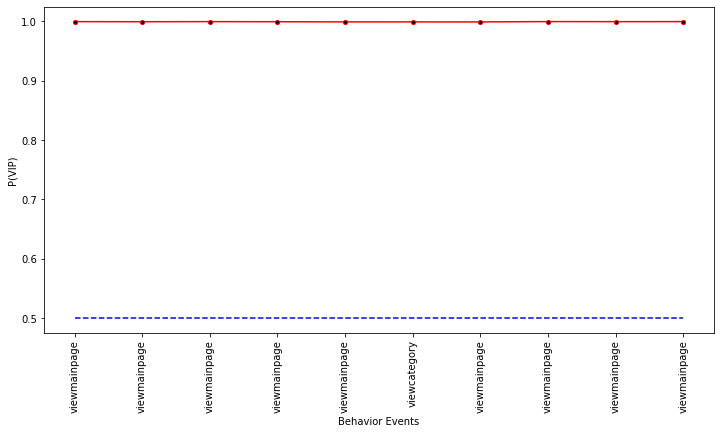

In [ ]:
output_ex(2)

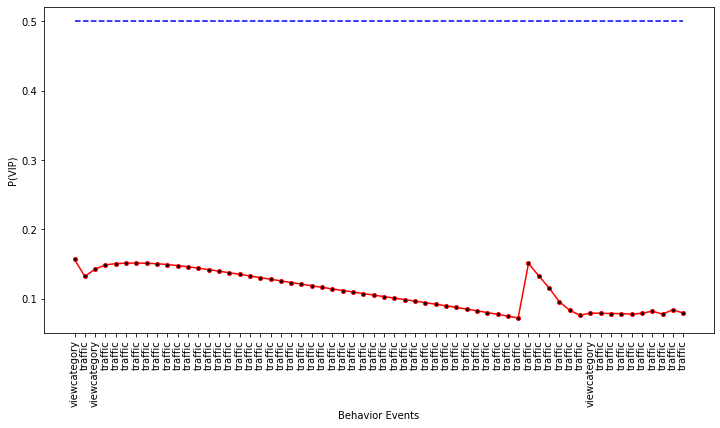

In [ ]:
output_ex(200)

## Tune LSTM

In [ ]:
def tune_LSTM(X_train, y_train, X_test, y_test, embedding_num, layers, neurons, lr, epochs, batch_size):
  model = Sequential()
  model.add(Embedding(input_dim=11, output_dim=embedding_num))
  model.add(LSTM(neurons, input_shape=(PADDING_LENGTH, embedding_num), return_sequences=True))

  if layers > 1:
    for i in range(1, layers):
      model.add(LSTM(neurons, return_sequences=True))

  model.add(Dense(1, activation='sigmoid'))

  decay_rate = lr / epochs
  opt = Adam(learning_rate=lr, decay=decay_rate)

  # Classification
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  callback = EarlyStopping(monitor='loss', patience=3)
  history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[callback])

  prediction = model.predict(X_test)
  y_pred = (prediction[:, PADDING_LENGTH-1] > 0.5)
  test_acc = accuracy_score(y_pred, y_test)
  test_f1 = f1_score(y_pred, y_test)
  test_AUC = roc_auc_score(y_pred, y_test)

  result = {
      'train_acc': history.history['accuracy'][-1],
      'val_acc': history.history['val_accuracy'][-1],
      'test_acc': test_acc,
      'test_f1': test_f1,
      'test_AUC': test_AUC
  }
  return result

In [ ]:
EPOCHS = 20
BATCH_SIZE = 512
LR = 0.01 

In [ ]:
embedding_nums = [6, 8 ,10 ,16]
layers = [1, 2, 3]
neurons = [8, 16, 32, 64]

### Embedding Neurons

In [ ]:
LAYERS = 1
NEURONS = 32

In [ ]:
model_list = []

for embedding_num in embedding_nums:
  print(embedding_num)
  model = tune_LSTM(X_train, y_train, X_test, y_test, embedding_num, LAYERS, NEURONS, LR, EPOCHS, BATCH_SIZE)
  model_list.append(model)

6
Epoch 1/20
28/28 [==============================] - 13s 194ms/step - loss: 0.4020 - accuracy: 0.8366 - val_loss: 0.3207 - val_accuracy: 0.8926
Epoch 2/20
28/28 [==============================] - 5s 186ms/step - loss: 0.3107 - accuracy: 0.8977 - val_loss: 0.3139 - val_accuracy: 0.8954
Epoch 3/20
28/28 [==============================] - 5s 163ms/step - loss: 0.3049 - accuracy: 0.8990 - val_loss: 0.3039 - val_accuracy: 0.8968
Epoch 4/20
28/28 [==============================] - 4s 149ms/step - loss: 0.2947 - accuracy: 0.8997 - val_loss: 0.2868 - val_accuracy: 0.9003
Epoch 5/20
28/28 [==============================] - 4s 151ms/step - loss: 0.2750 - accuracy: 0.9039 - val_loss: 0.3023 - val_accuracy: 0.8915
Epoch 6/20
28/28 [==============================] - 5s 180ms/step - loss: 0.2657 - accuracy: 0.9029 - val_loss: 0.2635 - val_accuracy: 0.9015
Epoch 7/20
28/28 [==============================] - 5s 162ms/step - loss: 0.2572 - accuracy: 0.9057 - val_loss: 0.2581 - val_accuracy: 0.9034
Epo

In [ ]:
result_df = pd.DataFrame(model_list)

In [ ]:
result_df

,train_acc,val_acc,test_acc,test_f1,test_AUC
0,0.911587,0.903511,0.939286,0.937298,0.943270
1,0.910766,0.907729,0.932813,0.933890,0.932752
2,0.911999,0.907296,0.949554,0.948636,0.951560
3,0.910729,0.908571,0.953348,0.952511,0.955339


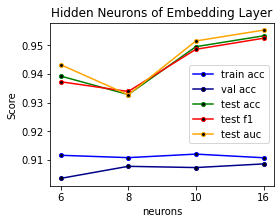

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(range(len(embedding_nums)), result_df['train_acc'], color="blue", marker='o', markerfacecolor='black', markersize=4,  label='train acc')
plt.plot(range(len(embedding_nums)), result_df['val_acc'], color="darkblue", marker='o', markerfacecolor='black', markersize=4, label='val acc')
plt.plot(range(len(embedding_nums)), result_df['test_acc'], color="green", marker='o', markerfacecolor='black', markersize=4, label='test acc')
plt.plot(range(len(embedding_nums)), result_df['test_f1'], color="red", marker='o', markerfacecolor='black', markersize=4, label='test f1')
plt.plot(range(len(embedding_nums)), result_df['test_AUC'], color="orange", marker='o', markerfacecolor='black', markersize=4, label='test auc')
plt.xticks(range(len(embedding_nums)), embedding_nums)
plt.title('Hidden Neurons of Embedding Layer')
plt.xlabel('neurons')
plt.ylabel('Score')
plt.legend()
plt.show()

### LSTM Layers

In [ ]:
EMBEDDING = 16
NEURONS = 32

In [ ]:
model_list = []

for layer in layers:
  print(layer)
  model = tune_LSTM(X_train, y_train, X_test, y_test, EMBEDDING, layer, NEURONS, LR, EPOCHS, BATCH_SIZE)
  model_list.append(model)

1
Epoch 1/20
28/28 [==============================] - 6s 128ms/step - loss: 0.3784 - accuracy: 0.8601 - val_loss: 0.3170 - val_accuracy: 0.8945
Epoch 2/20
28/28 [==============================] - 3s 111ms/step - loss: 0.3079 - accuracy: 0.8984 - val_loss: 0.3066 - val_accuracy: 0.8956
Epoch 3/20
28/28 [==============================] - 3s 111ms/step - loss: 0.2929 - accuracy: 0.8990 - val_loss: 0.2804 - val_accuracy: 0.8964
Epoch 4/20
28/28 [==============================] - 3s 111ms/step - loss: 0.2724 - accuracy: 0.8997 - val_loss: 0.2738 - val_accuracy: 0.8995
Epoch 5/20
28/28 [==============================] - 3s 110ms/step - loss: 0.2705 - accuracy: 0.9031 - val_loss: 0.2736 - val_accuracy: 0.8998
Epoch 6/20
28/28 [==============================] - 3s 110ms/step - loss: 0.2637 - accuracy: 0.9037 - val_loss: 0.2663 - val_accuracy: 0.8990
Epoch 7/20
28/28 [==============================] - 3s 111ms/step - loss: 0.2617 - accuracy: 0.9041 - val_loss: 0.2620 - val_accuracy: 0.9021
Epoc

In [ ]:
result_df = pd.DataFrame(model_list)

In [ ]:
result_df

,train_acc,val_acc,test_acc,test_f1,test_AUC
0,0.911119,0.908087,0.941518,0.941933,0.941599
1,0.912452,0.909826,0.952232,0.951953,0.953030
2,0.912056,0.906831,0.948884,0.947753,0.951379


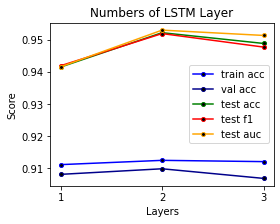

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(range(len(layers)), result_df['train_acc'], color="blue", marker='o', markerfacecolor='black', markersize=4,  label='train acc')
plt.plot(range(len(layers)), result_df['val_acc'], color="darkblue", marker='o', markerfacecolor='black', markersize=4, label='val acc')
plt.plot(range(len(layers)), result_df['test_acc'], color="green", marker='o', markerfacecolor='black', markersize=4, label='test acc')
plt.plot(range(len(layers)), result_df['test_f1'], color="red", marker='o', markerfacecolor='black', markersize=4, label='test f1')
plt.plot(range(len(layers)), result_df['test_AUC'], color="orange", marker='o', markerfacecolor='black', markersize=4, label='test auc')
plt.xticks(range(len(layers)), layers)
plt.title('Numbers of LSTM Layer')
plt.xlabel('Layers')
plt.ylabel('Score')
plt.legend()
plt.show()

### Hidden Neurons of LSTM Layers

In [ ]:
EMBEDDING = 16
LAYERS = 2

In [ ]:
model_list = []

for neuron in neurons:
  print(neuron)
  model = tune_LSTM(X_train, y_train, X_test, y_test, EMBEDDING, LAYERS, neuron, LR, EPOCHS, BATCH_SIZE)
  model_list.append(model)

8
Epoch 1/20
28/28 [==============================] - 11s 150ms/step - loss: 0.4103 - accuracy: 0.8641 - val_loss: 0.3242 - val_accuracy: 0.8925
Epoch 2/20
28/28 [==============================] - 2s 81ms/step - loss: 0.3136 - accuracy: 0.8970 - val_loss: 0.3156 - val_accuracy: 0.8937
Epoch 3/20
28/28 [==============================] - 2s 81ms/step - loss: 0.3087 - accuracy: 0.8974 - val_loss: 0.3133 - val_accuracy: 0.8943
Epoch 4/20
28/28 [==============================] - 2s 81ms/step - loss: 0.3046 - accuracy: 0.8976 - val_loss: 0.3094 - val_accuracy: 0.8947
Epoch 5/20
28/28 [==============================] - 2s 82ms/step - loss: 0.2984 - accuracy: 0.8983 - val_loss: 0.2990 - val_accuracy: 0.8953
Epoch 6/20
28/28 [==============================] - 3s 117ms/step - loss: 0.2903 - accuracy: 0.8995 - val_loss: 0.2943 - val_accuracy: 0.8987
Epoch 7/20
28/28 [==============================] - 3s 115ms/step - loss: 0.2869 - accuracy: 0.9025 - val_loss: 0.2917 - val_accuracy: 0.8996
Epoch 8

In [ ]:
result_df = pd.DataFrame(model_list)

In [ ]:
result_df

,train_acc,val_acc,test_acc,test_f1,test_AUC
0,0.910116,0.906841,0.943750,0.943523,0.944406
1,0.911830,0.909408,0.933705,0.935025,0.933674
2,0.912150,0.907217,0.952902,0.952381,0.954154
3,0.912672,0.908994,0.951562,0.950916,0.953039


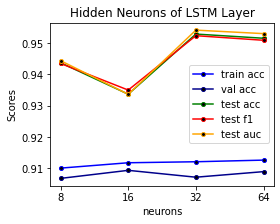

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(range(len(neurons)), result_df['train_acc'], color="blue", marker='o', markerfacecolor='black', markersize=4,  label='train acc')
plt.plot(range(len(neurons)), result_df['val_acc'], color="darkblue", marker='o', markerfacecolor='black', markersize=4, label='val acc')
plt.plot(range(len(neurons)), result_df['test_acc'], color="green", marker='o', markerfacecolor='black', markersize=4, label='test acc')
plt.plot(range(len(neurons)), result_df['test_f1'], color="red", marker='o', markerfacecolor='black', markersize=4, label='test f1')
plt.plot(range(len(neurons)), result_df['test_AUC'], color="orange", marker='o', markerfacecolor='black', markersize=4, label='test auc')
plt.xticks(range(len(neurons)), neurons)
plt.title('Hidden Neurons of LSTM Layer')
plt.xlabel('neurons')
plt.ylabel('Scores')
plt.legend()
plt.show()

### 決定 learning rate

In [ ]:
EMBEDDING = 16
LAYERS = 2
NEURONS = 32

EPOCHS = 20
BATCH_SIZE = 512
LRs = [0.1, 0.01, 0.001]

In [ ]:
model_list = []

for LR in LRs:
  print(LR)
  model = tune_LSTM(X_train, y_train, X_test, y_test, EMBEDDING, LAYERS, NEURONS, LR, EPOCHS, BATCH_SIZE)
  model_list.append(model)

0.1
Epoch 1/20
28/28 [==============================] - 10s 240ms/step - loss: 0.3934 - accuracy: 0.8382 - val_loss: 0.2995 - val_accuracy: 0.8982
Epoch 2/20
28/28 [==============================] - 6s 209ms/step - loss: 0.2850 - accuracy: 0.8999 - val_loss: 0.2727 - val_accuracy: 0.8988
Epoch 3/20
28/28 [==============================] - 6s 210ms/step - loss: 0.2742 - accuracy: 0.9021 - val_loss: 0.2726 - val_accuracy: 0.8972
Epoch 4/20
28/28 [==============================] - 6s 212ms/step - loss: 0.2652 - accuracy: 0.9042 - val_loss: 0.2697 - val_accuracy: 0.8986
Epoch 5/20
28/28 [==============================] - 6s 210ms/step - loss: 0.2614 - accuracy: 0.9049 - val_loss: 0.2541 - val_accuracy: 0.9032
Epoch 6/20
28/28 [==============================] - 6s 211ms/step - loss: 0.2646 - accuracy: 0.9028 - val_loss: 0.2585 - val_accuracy: 0.9023
Epoch 7/20
28/28 [==============================] - 6s 212ms/step - loss: 0.2537 - accuracy: 0.9075 - val_loss: 0.2609 - val_accuracy: 0.9028
E

In [ ]:
result_df = pd.DataFrame(model_list)

In [ ]:
result_df

,train_acc,val_acc,test_acc,test_f1,test_AUC
0,0.910011,0.908780,0.950670,0.950011,0.952144
1,0.912465,0.909315,0.952902,0.952510,0.953905
2,0.908236,0.904432,0.905134,0.908935,0.906097


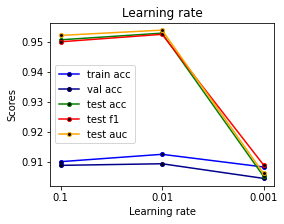

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(range(len(LRs)), result_df['train_acc'], color="blue", marker='o', markerfacecolor='black', markersize=4,  label='train acc')
plt.plot(range(len(LRs)), result_df['val_acc'], color="darkblue", marker='o', markerfacecolor='black', markersize=4, label='val acc')
plt.plot(range(len(LRs)), result_df['test_acc'], color="green", marker='o', markerfacecolor='black', markersize=4, label='test acc')
plt.plot(range(len(LRs)), result_df['test_f1'], color="red", marker='o', markerfacecolor='black', markersize=4, label='test f1')
plt.plot(range(len(LRs)), result_df['test_AUC'], color="orange", marker='o', markerfacecolor='black', markersize=4, label='test auc')
plt.xticks(range(len(LRs)), LRs)
plt.title('Learning rate')
plt.xlabel('Learning rate')
plt.ylabel('Scores')
plt.legend()
plt.show()

In [ ]:
model_list[1]

{'test_AUC': 0.9539054437583808,
 'test_acc': 0.9529017857142857,
 'test_f1': 0.9525095656088229,
 'train_acc': 0.91246497631073,
 'val_acc': 0.9093145728111267}

## 最佳 model 訓練

In [ ]:
model = Sequential()
  
model.add(Embedding(input_dim=11, output_dim=16))
model.add(LSTM(32, input_shape=(PADDING_LENGTH, 16), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

decay_rate = 0.01 / 20
opt = Adam(lr=0.01, decay=decay_rate)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, None, 16)          176       
                                                                 
 lstm_45 (LSTM)              (None, None, 32)          6272      
                                                                 
 lstm_46 (LSTM)              (None, None, 32)          8320      
                                                                 
 dense_31 (Dense)            (None, None, 1)           33        
                                                                 
Total params: 14,801
Trainable params: 14,801
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)
EPOCHS = 20
BATCH_SIZE = 512
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=[callback], verbose=1)

Epoch 1/20
28/28 [==============================] - 11s 241ms/step - loss: 0.3731 - accuracy: 0.8589 - val_loss: 0.3190 - val_accuracy: 0.8935
Epoch 2/20
28/28 [==============================] - 6s 206ms/step - loss: 0.3092 - accuracy: 0.8984 - val_loss: 0.3123 - val_accuracy: 0.8951
Epoch 3/20
28/28 [==============================] - 6s 206ms/step - loss: 0.3061 - accuracy: 0.8990 - val_loss: 0.3069 - val_accuracy: 0.8963
Epoch 4/20
28/28 [==============================] - 6s 207ms/step - loss: 0.2968 - accuracy: 0.9000 - val_loss: 0.2948 - val_accuracy: 0.8979
Epoch 5/20
28/28 [==============================] - 6s 207ms/step - loss: 0.2791 - accuracy: 0.9013 - val_loss: 0.2685 - val_accuracy: 0.8983
Epoch 6/20
28/28 [==============================] - 6s 207ms/step - loss: 0.2647 - accuracy: 0.9047 - val_loss: 0.2620 - val_accuracy: 0.9032
Epoch 7/20
28/28 [==============================] - 6s 206ms/step - loss: 0.2604 - accuracy: 0.9067 - val_loss: 0.2587 - val_accuracy: 0.9053
Epoch

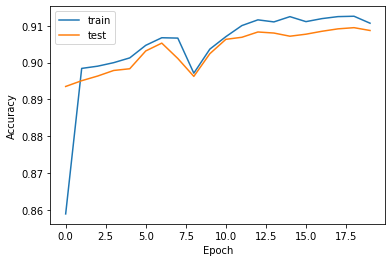

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
prediction = model.predict(X_test)

In [ ]:
y_pred = (prediction[:, PADDING_LENGTH-1] > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1 score: ', f1_score(y_pred, y_test))
print('AUC score: ', roc_auc_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.9515625
F1 score:  0.9507601542999774
AUC score:  0.9533875600362071
Confusion matrix:


array([[2168,   26],
       [ 191, 2095]])

In [ ]:
labels = ['NotVIP', 'VIP']

In [ ]:
Counter(y_test)

Counter({0.0: 2194, 1.0: 2286})

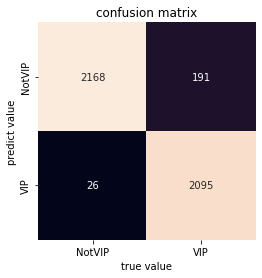

In [ ]:
matric = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(4,4))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",classification_report(y_pred, y_test,labels=[0, 1],target_names=labels))

report:
               precision    recall  f1-score   support

      NotVIP       0.99      0.92      0.95      2359
         VIP       0.92      0.99      0.95      2121

    accuracy                           0.95      4480
   macro avg       0.95      0.95      0.95      4480
weighted avg       0.95      0.95      0.95      4480



In [ ]:
prediction_all = model.predict(np.array(X).reshape(len(X), PADDING_LENGTH, 1))

In [ ]:
y_pred_all = (prediction_all[:, -1] > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred_all, y))
print('F1 score: ', f1_score(y_pred_all, y))
print('AUC score: ', roc_auc_score(y_pred_all, y))
print('Confusion matrix:')
confusion_matrix(y_pred_all, y)

Accuracy of the model :  0.2833041426886371
F1 score:  0.2561673818150342
AUC score:  0.5448820737772077
Confusion matrix:


array([[13420,   840],
       [59313, 10358]])

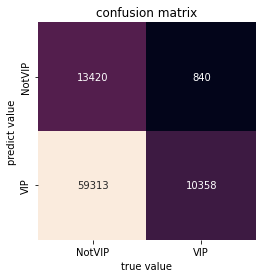

In [ ]:
matric = confusion_matrix(y_pred_all, y)
plt.figure(figsize=(4,4))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",classification_report(y_pred_all, y,labels=[0, 1],target_names=labels))

report:
               precision    recall  f1-score   support

      NotVIP       0.18      0.94      0.31     14260
         VIP       0.92      0.15      0.26     69671

    accuracy                           0.28     83931
   macro avg       0.55      0.54      0.28     83931
weighted avg       0.80      0.28      0.27     83931



## 取得每層 layer output

In [ ]:
model.layers[0].get_weights()[0].shape

(11, 16)

In [ ]:
def get_layer_output(X, idx):
  get_output = K.function([model.layers[0].input], [model.layers[idx].output])
  return get_output([X])

In [ ]:
embedding_layer = get_layer_output(X_test, 0)
output_layer = get_layer_output(X_test, 3)
all_output_layer = get_layer_output(X_uds, 3)
# layer_output_3 = get_layer_output(X_test, 2)
# layer_output_5 = get_layer_output(X_test, 4)

In [ ]:
len(all_output_layer[0])

22396

In [ ]:
len(output_layer[0])

4480

In [ ]:
ot = pd.DataFrame(output_layer[0][:, PADDING_LENGTH-1], columns=['P'])
ot[ot['P']>0.5]

,P
0,0.999912
3,0.999801
4,0.999895
5,0.999914
6,0.999600
...,...
4471,0.999702
4472,0.999916
4475,0.999915
4476,0.999858


## 結果解釋

In [ ]:
bh_dict = ['None', 'add', 'checkout', 'purchase', 'register', 'search', 'traffic', 'viewactivity', 'viewcategory', 'viewmainpage', 'viewproduct']

In [ ]:
def get_output_df(idx, data, output_layer):
  bh_eg = list(data[idx].reshape(1,PADDING_LENGTH)[0])
  bh_eg = [i for i in bh_eg if i != 0] # 把 padding 的 event 拿掉
  output_eg = list(output_layer[0][idx].reshape(1,PADDING_LENGTH)[0])[-len(bh_eg):]
  bh_name_eg = [bh_dict[x] for x in bh_eg]

  df_eg = pd.DataFrame([idx] * len(bh_eg), columns=['Member'])
  df_eg['bh'] = bh_name_eg
  df_eg['Output'] = output_eg

  return df_eg

### 取得 all output of test data

In [ ]:
df_egs = []
for i in range(len(X_test)):
  df_eg = get_output_df(i, X_test, output_layer)
  df_egs.append(df_eg)

In [ ]:
test_output = pd.concat(df_egs)

In [ ]:
len(test_output['Member'].unique())

4480

In [ ]:
test_output.to_csv('Event Sequence Outputs for test data.csv', index=False)

### 取得 all output of all undersampled data

In [ ]:
df_egs = []
for i in range(len(X_uds)):
  df_eg = get_output_df(i, X_uds, all_output_layer)
  df_egs.append(df_eg)

In [ ]:
all_output = pd.concat(df_egs)

In [ ]:
len(all_output['Member'].unique())

22396

In [ ]:
all_output.to_csv('Event Sequence Outputs.csv', index=False)

### 整理 ALL data output

In [ ]:
all_output

,Member,bh,Output
0,0,viewmainpage,0.089915
1,0,viewmainpage,0.091846
2,0,viewcategory,0.093958
0,1,viewmainpage,0.087862
1,1,viewmainpage,0.090038
...,...,...,...
55,22395,viewmainpage,0.999752
56,22395,viewmainpage,0.999732
57,22395,viewmainpage,0.999713
58,22395,viewproduct,0.999857


## 繪圖

In [ ]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [ ]:
def output_ex(idx):
  eg_1 = list(X_uds[idx].reshape(1,PADDING_LENGTH)[0])
  eg_1 = [i for i in eg_1 if i != 0] # 把 padding 的 event 拿掉
  output_1 = list(all_output_layer[0][idx].reshape(1,PADDING_LENGTH)[0])[-len(eg_1):]

  # 開始繪圖
  x_axis = range(len(eg_1))
  base = [0.5] * len(x_axis)
  eg_1_bh = [bh_dict[x] for x in eg_1]

  plt.figure(figsize=(12,6))
  plt.tight_layout()
  plt.plot(x_axis, output_1, color="red", marker='o', markerfacecolor='black', markersize=4)
  plt.plot(x_axis, base, color="blue", linestyle='dashed')
  plt.xticks(x_axis,eg_1_bh,rotation=90)
  plt.xlabel('Behavior Events')
  plt.ylabel('P(VIP)')
  plt.savefig('Customer Value Prediction/IMG/Event Sequence Prediction/'+ str(idx)+'.png')
  plt.close()  

In [ ]:
# for i in range(len(X_uds)):
#   output_ex(i)

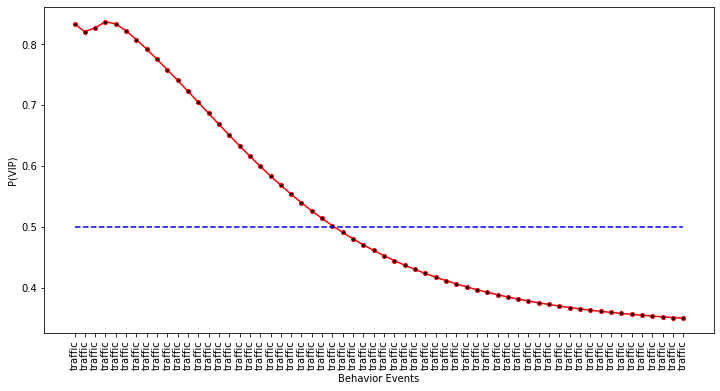

In [ ]:
output_ex(9)

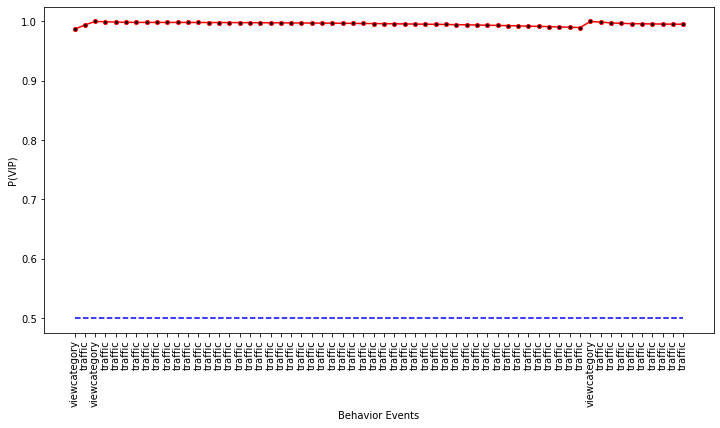

In [ ]:
output_ex(200)